In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import lru_cache, partial
import pandas as pd
import numpy as np
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from pandas.core.arrays.period import period_array
from transformers import InformerConfig, InformerForPrediction
from transformers import PretrainedConfig
from typing import Optional

from gluonts.transform.sampler import InstanceSampler


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from accelerate import Accelerator
from torch.optim import AdamW


In [2]:
tc_dataset = load_dataset("shaddie/thrust_curves_dataset")

In [44]:
def find_pad_max(dataset):
    l=len(dataset)
    m = 0
    for r in range(l):
        # real = tc_dataset[split][r]['feat_dynamic_real']
        target = dataset[r]['target']
        if m < len(target):
            m = len(target)

    return m


def pad_data(data, m, split):
    l=len(data)
    tc = []
    for r in range(l):
        real = data[r]['feat_dynamic_real']
        target = data[r]['target']
        rlen = len(real)
        pad = [0 for _ in range(61-rlen)]
        # target = tc_dataset['train'][r]['target']
        real = real + pad
        target = target + pad
        tc.append({
            'start': data[r]['start'],
            'target': target,
            'feat_static_cat': data[r]['feat_static_cat'],
            'feat_dynamic_real': real,
            'item_id': data[r]['item_id']
                }
            )
        
    return tc

In [45]:
from datasets import Dataset
m = find_pad_max(tc_dataset["train"])
split="train"

In [46]:
tc = pad_data(tc_dataset[split], m=m, split=split)

In [57]:
train_dataset=Dataset.from_list(tc)

In [64]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 266
})

In [65]:
freq = "1W"
prediction_length = 8

# assert len(train_example["target"]) + prediction_length == len(
#     dataset["validation"][0]["target"]
# )

In [66]:
train_example =train_dataset[0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

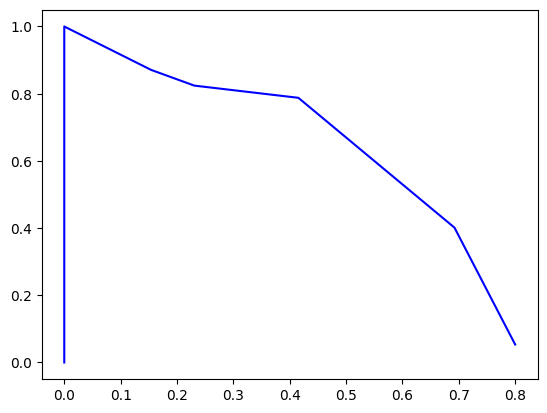

In [67]:
num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], 
          train_example["feat_dynamic_real"][-num_of_samples:],
          color="blue")

plt.show()

In [68]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [70]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
# test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [71]:
num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
# test_grouper = MultivariateGrouper(
#     max_target_dim=num_of_variates,
#     num_test_dates= None, # len(test_dataset)
#     num_of_variates  # number of rolling test windows
# )

multi_variate_train_dataset = train_grouper(train_dataset)
# multi_variate_test_dataset = test_grouper(test_dataset)

In [72]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (266, 99)


In [75]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_month at 0x12d65d3a0>, <function week_of_year at 0x12d65d760>]


Look back certain time range for each time step, as additional features "lags_sequence"

In [76]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157]


In [77]:
timestamp = pd.Period("2025-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_month': array([-0.36666667]), 'week_of_year': array([-0.5])}


In [78]:
config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)

In [79]:
model.config.distribution_output

'student_t'

In [80]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [81]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [84]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [85]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

In [86]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 184, 3]) torch.FloatTensor
past_values torch.Size([256, 184, 266]) torch.FloatTensor
past_observed_mask torch.Size([256, 184, 266]) torch.FloatTensor
future_time_features torch.Size([256, 8, 3]) torch.FloatTensor
future_values torch.Size([256, 8, 266]) torch.FloatTensor
future_observed_mask torch.Size([256, 8, 266]) torch.FloatTensor


In [96]:
from tqdm import tqdm
epochs = 150
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-5, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):   
    for idx, batch in enumerate(progress_bar):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 200 == 0:
            print(f'Epoch {epoch} & idx {idx} with loss: {loss.item()}')

Epoch 1/150 : 0it [00:00, ?it/s]


NameError: name 'total_loss' is not defined